In [30]:
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Task 1

Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it and figure out what it is due to.

In [31]:
# load MTA fare data
data = np.load('mta_fare.npy')

In [32]:
# replace negative values with NaN
data = np.where(data<0, 'NaN',data)

In [33]:
# then convert to float type
mta = data.astype(float)

In [34]:
# print data

# print data[0]

# print data[0][0]

# axis 0 = station
# axis 1 = rider type
# axis 2 = weeks

In [35]:
mta_stations = np.nanmean(mta, axis=(0,1))
rider_std = mta_stations.std()
rider_mean = mta_stations.mean()
# print mta_stations

In [36]:
# create weekly range over 194 weeks starting on May 21st, 2010
time = pd.date_range('5/21/2010', periods=194, freq='w')

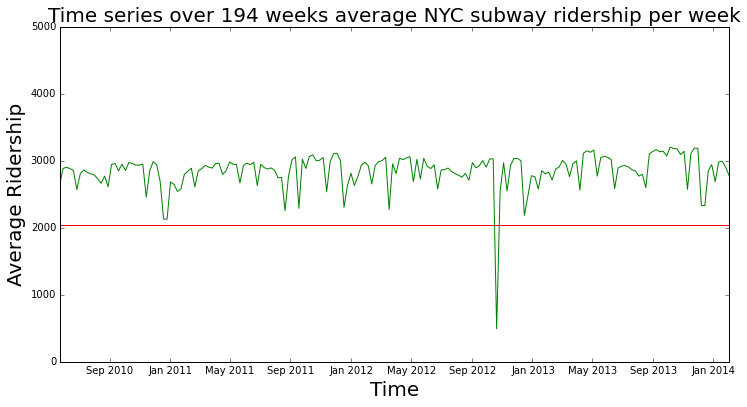

In [37]:
figure, ax = pl.subplots(figsize=(12,6))
ax.plot(time, np.transpose(mta_stations), color='green')
ax.set_ylim(0,5000)
axhline(y = (rider_mean - (3*rider_std)), color = 'red')
ax.set_title('Time series over 194 weeks average NYC subway ridership per week', fontsize=20)
pl.xlabel('Time', fontsize=20)
pl.ylabel('Average Ridership', fontsize=20)

In [38]:
# obviously, there is a significant event. we identify it by returning the min 
# value from the MTA data
disaster_event = time[mta_stations == min(mta_stations)]
print disaster_event

DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq='W-SUN')


####Looking at the graph, we can see that there is a significant event during Q4 2012 that caused subway ridership to drop considerably. By identifying the day of the minimum ridership, we can confirm that this was due to Hurricane Sandy on October 21st.

##Task 2

Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [39]:
station_mean = np.transpose(np.nansum(mta, axis = 0))

In [40]:
x = np.nanmean(mta, axis = 0)
nanmean(x[1][:10])

1152.5385598947321

In [41]:
# to detect an event, we want to analyze the difference between the start and end times of the period
# in this case, we will compare the first ten weeks and the last ten weeks of the 194-week period

# first, we calculate the first ten weeks
first10means = []

for i in arange(len(x)):
    first10means.append(nanmean(x[i][:10]))
    
print first10means

[26679.372192905088, 1152.5385598947321, 107.82019153323286, 411.90584448530944, 103.6370426946784, 8501.1077179042513, 19700.974263490909, 23.72845207243676, 707.62432465915231, 1294.7483984113428, 89.142768484208759, 284.98496346302073, 0.012525170215604647, 296.67120792346032, 1823.7820622874635, 139.40532536404152, 67.433917761431246, 0.98048010212026748, 261.15739818211034, 45.660587933121128, 14.317519397471528, 1.0289081702754841, nan]


In [42]:
# then, we calculate the last ten weeks
last10means = []

for j in arange(len(x)):
    last10means.append(nanmean(x[j][-10:]))
    
print last10means

[27298.114440473408, 1444.9642443790008, 119.9858862468285, 385.14660480439312, 107.26512760800135, 11830.198747580713, 17751.245660099281, 0.0049760256157280192, 0.0075715582328589074, 0.0019466494628481671, 73.090841533308378, 346.31075937667839, 311.03116237851998, 171.92342831859588, 1186.3084975574548, 361.96838249525666, 196.45849503034489, 68.936148924295864, 400.67785075602268, 46.704914794916803, 11.598836646129133, 1.7128068945401911, 2311.9974547509901]


In [43]:
# divide our last ten and first ten to create our ratio
ratio = numpy.divide(last10means,first10means)
print ratio

[  1.02319178e+00   1.25372312e+00   1.11283318e+00   9.35035543e-01
   1.03500761e+00   1.39160673e+00   9.01033899e-01   2.09707131e-04
   1.06999689e-05   1.50349633e-06   8.19930128e-01   1.21518958e+00
   2.48324899e+04   5.79508303e-01   6.50466151e-01   2.59651761e+00
   2.91334838e+00   7.03085649e+01   1.53423894e+00   1.02287152e+00
   8.10114959e-01   1.66468393e+00              nan]


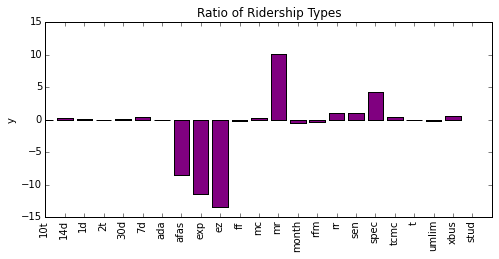

In [44]:
N = len(x)

rider_type = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

fix, ax = plt.subplots(figsize=(8,3.5))
width = 0.8
tickLocations = np.arange(N)
rectLocations = tickLocations - (width/2.0)
ax.bar(rectLocations, log(ratio), width, color = 'purple')
ax.set_xlim(0,23)
pl.xticks(tickLocations, rider_type, rotation = 'vertical')
pl.ylabel('y')
pl.title('Ratio of Ridership Types')

####Looking at the graph, we can see that the ADA Farecard Access System, Express, and EZPay ridership rates decreased over the period. Conversely, the Mail & Ride and Special ridership rates increased over the same period

##Task 3

Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

***columns are weeks,
rows are subway stations***

In [49]:
# pull out data from the cube so that we are observing ridership by station over the 194-week period
y = (np.nansum(mta, axis =1))
shape(y)

(600L, 194L)

Drop first two observations after performing the Fourier transformation, then find the values at the 52 week point and check for periodicity

In [55]:
top4stations = []

for i in range(len(y)):
    # Execute Fourier transformation
    f = np.abs(np.fft.rfft(y[i]))[2:]
    
    # Checks periodicity around 52 weeks
    if f[2] > (np.mean(f) + 7.5*np.std(f)):
        top4stations.append(i)

print "Top Four Stations: ", top4stations

Top Four Stations:  [0, 150, 194, 311]
